In [1]:
pip install torch torchvision

# Exercise 4: Transformers on Images + GLU-MLP Ablations (ViT × GLU Variants)

## In this exercise you will combine two influential ideas:

Vision Transformers (ViT) from “An Image is Worth 16×16 Words: Transformers for Image Recognition at Scale” (Dosovitskiy et al., 2020) https://arxiv.org/pdf/2010.11929 :
ViT shows that you can treat an image like a sequence of tokens by splitting it into non-overlapping patches (e.g. 16×16 in the paper), embedding each patch into a vector, adding positional information, and then applying standard Transformer blocks for classification.

Gated MLPs (GLU variants) from “GLU Variants Improve Transformer” (Shazeer, 2020) https://arxiv.org/pdf/2002.05202 :
Shazeer proposes replacing the standard Transformer feed-forward layer (FFN/MLP) with gated linear unit (GLU) variants such as GEGLU and SwiGLU, which often improves training dynamics and final performance under comparable compute/parameter budgets.

## What you will do

You will implement a tiny ViT-style classifier for MNIST, then run a controlled ablation where you replace the MLP inside each Transformer block:

Baseline FFN (GELU):
Linear(d_model → d_ff) → GELU → Linear(d_ff → d_model)

GLU-family MLPs (choose at least two and justify):

GEGLU, SwiGLU, other activation functions

Your goal is to evaluate whether these GLU variants change:

- convergence speed (loss vs steps),

- final test accuracy,

- and/or stability across runs.

## Key ViT concepts you will implement

- To convert MNIST images into Transformer tokens, you will:
  Patchify each 28×28 image into non-overlapping P×P patches.
  If P=4, then you get a 7×7 patch grid → 49 tokens per image.

- Embed patches with a linear layer: patch vectors → d_model.

- Add positional embeddings so the model knows where each patch came from.

- Apply n_layers Transformer encoder blocks.

- Pool token features (e.g., mean pooling) and project to 10 classes.

## Key GLU concept you will implement

GLU-style MLPs replace a standard FFN with a gating mechanism:
compute two projections a and b, apply a nonlinearity to a (variant-dependent), multiply elementwise: act(a) * b, project back to d_model.
To keep the comparison fair, use the 2/3 width rule from Shazeer.

What we provide vs what you implement

### We provide:

- MNIST loading + dataloaders

- a minimal training loop structure (AdamW)

- a suggested small model configuration that runs on CPU

### You implement:

- patch tokenization (patchify)

- patch embedding + positional embedding strategy

- a pre-LN Transformer encoder block using nn.MultiheadAttention

- at least two GLU MLP variants + one FFN baseline

- metric logging sufficient to support your conclusion

## Deliverables

Run at least 3 variants (baseline + the activation functions you choose for GLU) and report:

- final and best test accuracy

- number of trainable parameters

- a plot or printed summary of loss/accuracy over epochs

- a short discussion of your results

In [2]:
from __future__ import annotations

import math
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
def patchify(x: torch.Tensor, patch_size: int) -> torch.Tensor:
    """Convert images to patch tokens."""
    B, C, H, W = x.shape
    assert H % patch_size == 0 and W % patch_size == 0, "Image dimensions must be divisible by patch size."
    x = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    x = x.contiguous().view(B, C, -1, patch_size * patch_size)
    x = x.permute(0, 2, 1, 3).contiguous().view(B, -1, C * patch_size * patch_size)
    return x

#check works
if __name__ == "__main__":
    # Example usage
    batch_size = 1
    channels = 1
    height = 28
    width = 28
    patch_size = 4

    # Create a random tensor simulating a batch of images
    images = torch.randn(batch_size, channels, height, width)

    # Patchify the images
    patches = patchify(images, patch_size)

    print(f"Original shape: {images.shape}")
    print(f"Patchified shape: {patches.shape}")
    # Expected output shape: (batch_size, num_patches, patch_dim)
    expected_num_patches = (height // patch_size) * (width // patch_size)
    expected_patch_dim = channels * patch_size * patch_size
    assert patches.shape == (batch_size, expected_num_patches, expected_patch_dim), "Patchified shape is incorrect."


Original shape: torch.Size([1, 1, 28, 28])
Patchified shape: torch.Size([1, 49, 16])


In [4]:
# TODO: Add positional encoding as done in the ViT paper and patch projection
class PatchEmbed(nn.Module):
    def __init__(self, patch_dim: int, d_model: int):
        super().__init__()
        self.proj = nn.Linear(patch_dim, d_model)


    def forward(self, x_patches: torch.Tensor) -> torch.Tensor:
        return self.proj(x_patches)


class PositionalEmbedding(nn.Module):
    def __init__(self, num_tokens: int, d_model: int):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.empty(1, num_tokens, d_model))
        nn.init.xavier_uniform_(self.pos_embedding)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pos_embedding



In [5]:
# TODO: Define the variants you want to compare against each other from the GLU paper. Justify your choice.
class FeedForward(nn.Module):
    """
    Standard Transformer FFN:
      x -> Linear(d_model->d_ff) -> GELU -> Dropout -> Linear(d_ff->d_model) -> Dropout
    """
    def __init__(self, d_model: int, d_ff: int, dropout: float):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.activation = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        return x


class GLUFeedForward(nn.Module):
    """GLU-family FFN"""
    def __init__(self, d_model: int, d_ff_gated: int, dropout: float, variant: str = 'swiglu'):
        super().__init__()
        self.variant = variant.lower()

        # We project the input into two vectors (W and V) simultaneously.
        # This is equivalent to having two linear layers but more efficient.
        # Shape: [d_model, 2 * d_ff_gated]
        self.w_gate_linear = nn.Linear(d_model, d_ff_gated * 2)

        # The output projection layer (W2)
        self.w_out = nn.Linear(d_ff_gated, d_model)

        self.dropout = nn.Dropout(dropout)

        if self.variant not in ['geglu', 'swiglu']:
            raise ValueError("Variant must be 'geglu' or 'swiglu'")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 1. Project to 2 * d_ff_gated
        projected = self.w_gate_linear(x)

        # 2. Split into two halves: xW (gate) and xV (linear)
        x_gate, x_linear = projected.chunk(2, dim=-1)

        # 3. Apply activation to the gate component
        if self.variant == 'geglu':
            x_gate = F.gelu(x_gate)
        elif self.variant == 'swiglu':
            # Swish with beta=1 is equivalent to SiLU
            x_gate = F.silu(x_gate)

        # 4. Element-wise multiplication (The "Gating" mechanism)
        x = x_gate * x_linear

        # 5. Dropout
        x = self.dropout(x)

        # 6. Output projection
        x = self.w_out(x)

        return x

*Justification for chosen GLU variants:*

According to the paper's experimental results (Tables 1, 2, and 3), GEGLU and SwiGLU produced the lowest (best) log-perplexity results during pre-training on the C4 dataset compared to other variants like ReGLU or Bilinear.

SwiGLU has since become the standard for state-of-the-art LLMs (including LLaMA, PaLM, and Mistral), making it the most practically relevant variant to implement. GEGLU is the direct "GLU-fied" evolution of the standard GELU activation used in BERT/GPT-2. So both variants seemed interesting to implement and compare against the baseline FFN.



In [6]:
class TransformerEncoderBlock(nn.Module):
    """
    Pre-LN encoder block:
      x = x + Dropout(SelfAttn(LN(x)))
      x = x + Dropout(MLP(LN(x)))
    """
    def __init__(self, d_model: int, n_heads: int, mlp: nn.Module, dropout: float):
        super().__init__()
        # Pre-layer norms
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

        # Multi-head self-attention (batch_first so x is (B, T, D))
        self.self_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True,
        )

        # Feed-forward / MLP block (standard FFN or GLUFFN, passed in)
        self.mlp = mlp

        # Dropouts on residual branches
        self.dropout_attn = nn.Dropout(dropout)
        self.dropout_mlp = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, D)
        return: (B, T, D)
        """
        # Self-attention sub-layer
        x_norm = self.ln1(x)
        attn_out, _ = self.self_attn(x_norm, x_norm, x_norm)
        x = x + self.dropout_attn(attn_out)

        # MLP sub-layer
        x_norm = self.ln2(x)
        mlp_out = self.mlp(x_norm)
        x = x + self.dropout_mlp(mlp_out)

        return x

In [7]:
class TinyViT(nn.Module):
    """
    Tiny ViT-style classifier for MNIST.
    - patchify -> patch embed -> pos embed -> blocks -> mean pool -> head
    """
    def __init__(
        self,
        patch_size: int,
        d_model: int,
        n_heads: int,
        n_layers: int,
        d_ff: int,
        dropout: float,
        mlp_kind: str,
    ):
        super().__init__()
        assert 28 % patch_size == 0
        grid = 28 // patch_size
        self.num_tokens = grid * grid
        self.patch_size = patch_size
        patch_dim = patch_size * patch_size

        # TODO: implement a strategy for embedding the patches
        self.patch_embed = PatchEmbed(patch_dim=patch_dim, d_model=d_model)
        self.pos_embed = PositionalEmbedding(num_tokens=self.num_tokens, d_model=d_model)

        self.blocks = nn.ModuleList([])


        for _ in range(n_layers):
            # 1. Create a FRESH instance of the MLP for this specific block
            if mlp_kind == "standard":
                mlp_layer = FeedForward(d_model=d_model, d_ff=d_ff, dropout=dropout)
            elif mlp_kind == "geglu":
                # Optional: Adjust d_ff for fairness (approx 2/3)
                d_ff_gated = int(d_ff * 2/3)
                # d_ff_gated = d_ff alternative (NO FAIRNESS)
                mlp_layer = GLUFeedForward(d_model=d_model, d_ff_gated=d_ff_gated, dropout=dropout, variant="geglu")
            elif mlp_kind == "swiglu":
                # Optional: Adjust d_ff for fairness (approx 2/3)
                d_ff_gated = int(d_ff * 2/3)
                # d_ff_gated = d_ff alternative (NO FAIRNESS)
                mlp_layer = GLUFeedForward(d_model=d_model, d_ff_gated=d_ff_gated, dropout=dropout, variant="swiglu")
            else:
                raise ValueError(f"Unknown mlp_kind: {mlp_kind}")

            # 2. Pass the fresh instance to the block
            block = TransformerEncoderBlock(
                d_model=d_model,
                n_heads=n_heads,
                mlp=mlp_layer,
                dropout=dropout,
            )
            self.blocks.append(block)

        self.head = nn.Linear(d_model, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]

        # --- Patchify Logic ---

        # (B, 1, 28, 28) -> (B, 1, grid, patch, grid, patch)
        x = x.view(batch_size, 1, 28 // self.patch_size, self.patch_size, 28 // self.patch_size, self.patch_size)
        # Permute to (B, 1, grid, grid, patch, patch) then collapse
        x = x.permute(0, 2, 4, 1, 3, 5).contiguous()
        x = x.view(batch_size, self.num_tokens, -1) # (B, N, patch_dim)

        # Embeddings
        x = self.patch_embed(x)
        x = self.pos_embed(x)

        # Blocks
        for block in self.blocks:
            x = block(x)

        # Head
        x = x.mean(dim=1) # Global Average Pooling
        logits = self.head(x)

        return logits

In [8]:
@dataclass(frozen=True)
class TrainConfig:
    seed: int = 0
    batch_size: int = 128
    epochs: int = 3
    lr: float = 3e-4
    weight_decay: float = 0.01
    device: str = "cuda"  # set "cuda" if available

In [9]:
def train_one_run(
    mlp_kind: str,
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    cfg: TrainConfig,
) -> dict:
    model.to(cfg.device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    # Standard classification loss
    criterion = nn.CrossEntropyLoss() #could use ex3's crossentropy_from_logits too

    train_losses: list[float] = []
    test_accs: list[float] = []

    for epoch in range(cfg.epochs):

        # Train loop
        model.train()
        for i, (xb, yb) in enumerate(train_loader):
            xb = xb.to(cfg.device)
            yb = yb.to(cfg.device)

            logits = model(xb)
            loss = criterion(logits, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_losses.append(loss.item())

        # Evaluation loop NOTE: Should be no need to change this
        model.eval()
        correct = 0.0
        total = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(cfg.device)
                yb = yb.to(cfg.device)
                logits = model(xb)
                correct += (logits.argmax(dim=-1) == yb).float().sum().item()
                total += yb.numel()

        acc = correct / total
        test_accs.append(acc)
        print(f"[{mlp_kind}] epoch {epoch+1}/{cfg.epochs} | test acc: {test_accs[-1]:.4f}")

    return {
        # TODO: Return your metrics
        "kind": mlp_kind,
        "train_losses": train_losses,  # Useful for plotting convergence speed
        "test_accs": test_accs,        # Useful for plotting stability/overfitting
        "final_acc": test_accs[-1],    # The final result
        "best_acc": max(test_accs)     # The peak performance
    }

One run only:


In [11]:
cfg = TrainConfig(seed=0, batch_size=128, epochs=5, lr=3e-4, weight_decay=0.01, device="cuda")

tfm = transforms.Compose([transforms.ToTensor()])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=0)

# Tiny model example. TODO: You're welcome to experiment with these parameters
patch_size = 4
d_model = 64
n_heads = 4
n_layers = 2
d_ff = 256
dropout = 0.1

# comparing Standard baseline vs the two best performing GLU variants
runs = ["standard", "geglu", "swiglu"]
results = []

print(f"Device: {cfg.device}")

for kind in runs:
    model = TinyViT(
        patch_size=patch_size,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        d_ff=d_ff,
        dropout=dropout,
        mlp_kind=kind,
    )

    # Calculate number of parameters to ensure fair comparison
    # (GLU variants should have d_ff reduced by ~2/3 to match Standard params)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # TODO: print anything you might want here
    print(f"Run: {kind.upper():<10} | Params: {num_params:,}")
    # Train
    out = train_one_run(kind, model, train_loader, test_loader, cfg)
    results.append(out)
    print("-" * 60)
# Simple summary table at the end
print("\nFinal Results Summary:")
print(f"{'Variant':<15} | {'Final Acc':<10} | {'Best Acc':<10}")
for res in results:
    print(f"{res['kind']:<15} | {res['final_acc']:.4f}     | {res['best_acc']:.4f}")

Device: cuda
Run: STANDARD   | Params: 104,842
[standard] epoch 1/5 | test acc: 0.8069
[standard] epoch 2/5 | test acc: 0.8959
[standard] epoch 3/5 | test acc: 0.9175
[standard] epoch 4/5 | test acc: 0.9328
[standard] epoch 5/5 | test acc: 0.9382
------------------------------------------------------------
Run: GEGLU      | Params: 104,754
[geglu] epoch 1/5 | test acc: 0.7938
[geglu] epoch 2/5 | test acc: 0.8777
[geglu] epoch 3/5 | test acc: 0.9145
[geglu] epoch 4/5 | test acc: 0.9319
[geglu] epoch 5/5 | test acc: 0.9439
------------------------------------------------------------
Run: SWIGLU     | Params: 104,754
[swiglu] epoch 1/5 | test acc: 0.8320
[swiglu] epoch 2/5 | test acc: 0.9110
[swiglu] epoch 3/5 | test acc: 0.9288
[swiglu] epoch 4/5 | test acc: 0.9407
[swiglu] epoch 5/5 | test acc: 0.9564
------------------------------------------------------------

Final Results Summary:
Variant         | Final Acc  | Best Acc  
standard        | 0.9382     | 0.9382
geglu           | 0.943

Multiple runs and nice plots:

Device: cuda
Running 5 trials with seeds: [0, 42, 123, 456, 789]


TRIAL 1/5 (seed=0)
Run: STANDARD   | Params: 104,842
[standard] epoch 1/5 | test acc: 0.8252
[standard] epoch 2/5 | test acc: 0.8977
[standard] epoch 3/5 | test acc: 0.9253
[standard] epoch 4/5 | test acc: 0.9344
[standard] epoch 5/5 | test acc: 0.9334
------------------------------------------------------------
Run: GEGLU      | Params: 104,754
[geglu] epoch 1/5 | test acc: 0.8474
[geglu] epoch 2/5 | test acc: 0.9107
[geglu] epoch 3/5 | test acc: 0.9396
[geglu] epoch 4/5 | test acc: 0.9462
[geglu] epoch 5/5 | test acc: 0.9582
------------------------------------------------------------
Run: SWIGLU     | Params: 104,754
[swiglu] epoch 1/5 | test acc: 0.8103
[swiglu] epoch 2/5 | test acc: 0.9025
[swiglu] epoch 3/5 | test acc: 0.9294
[swiglu] epoch 4/5 | test acc: 0.9456
[swiglu] epoch 5/5 | test acc: 0.9461
------------------------------------------------------------

TRIAL 2/5 (seed=42)
Run: STANDARD   | Params: 104,842

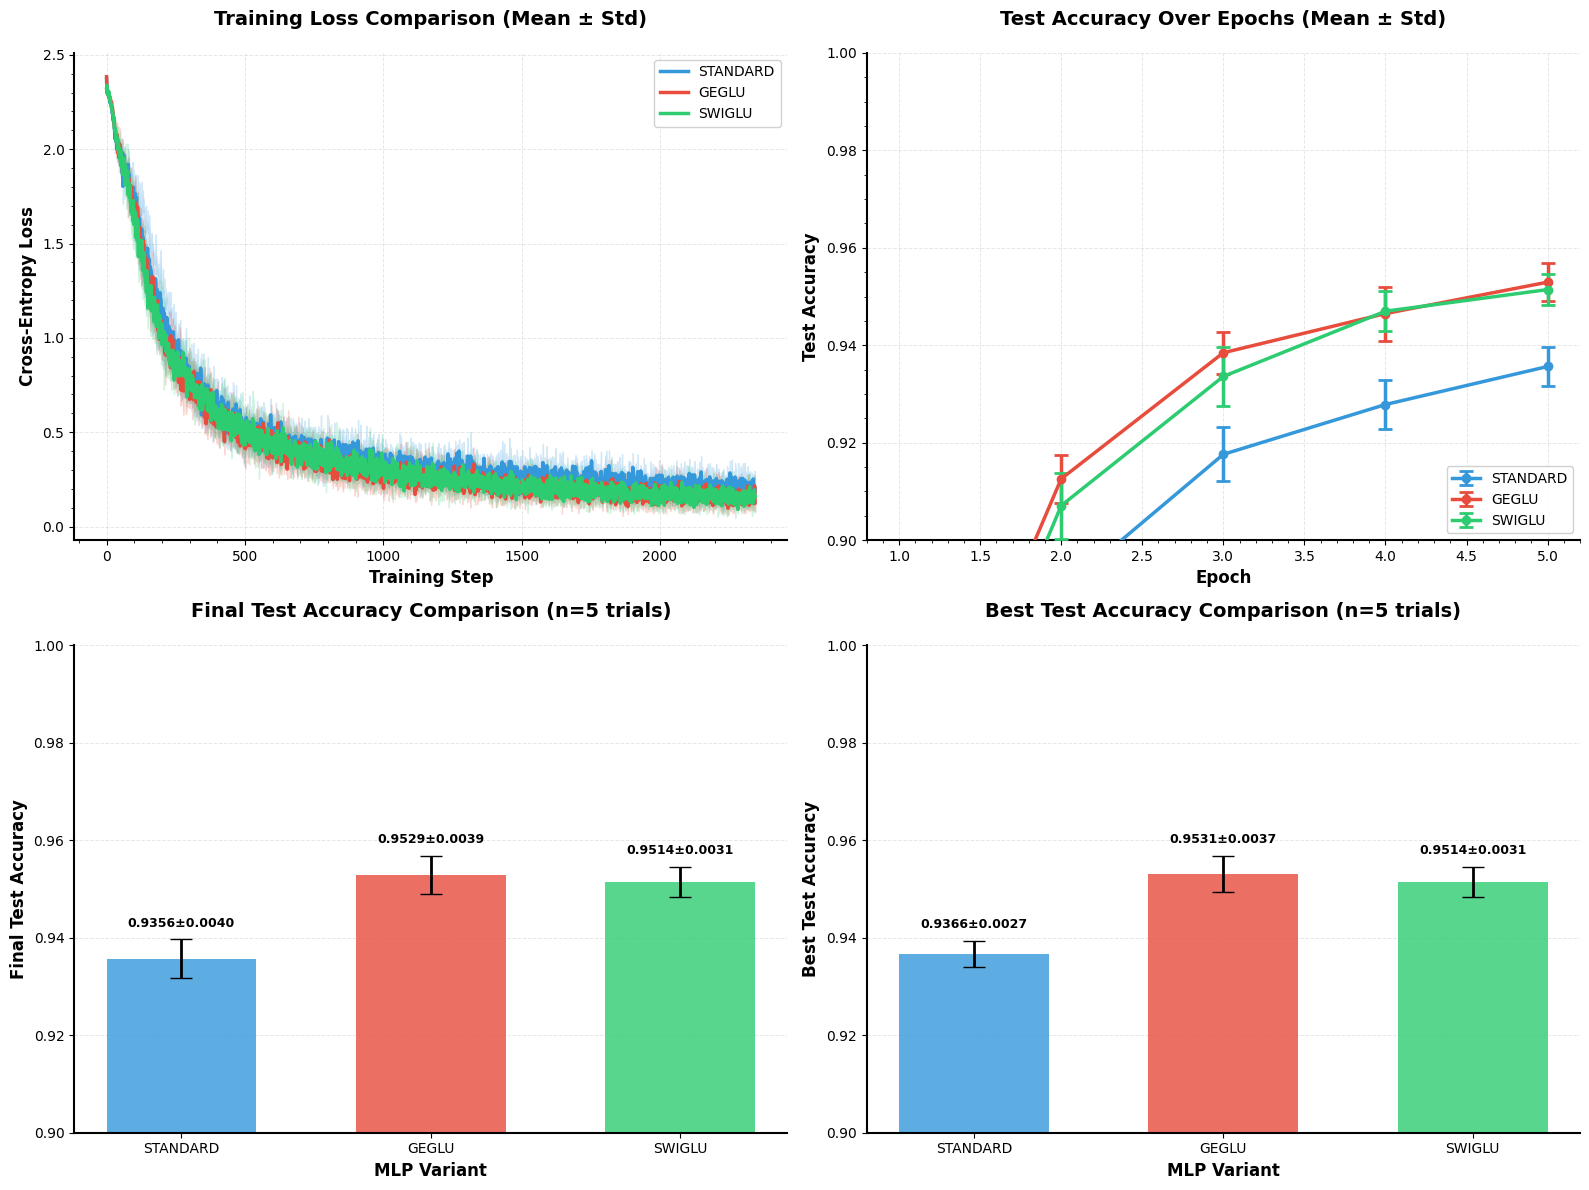

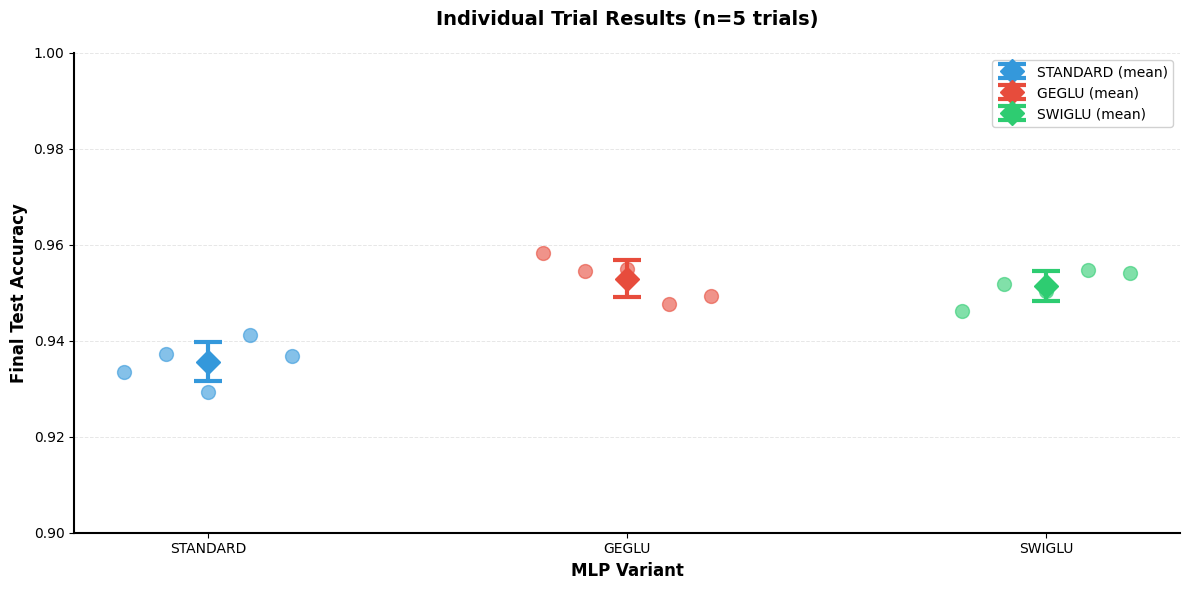

In [15]:
from dataclasses import replace

cfg = TrainConfig(seed=0, batch_size=128, epochs=5, lr=3e-4, weight_decay=0.01, device="cuda" if torch.cuda.is_available() else "cpu")

tfm = transforms.Compose([transforms.ToTensor()])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=0)

# Tiny model example. TODO: You're welcome to experiment with these parameters
patch_size = 4
d_model = 64
n_heads = 4
n_layers = 2
d_ff = 256
dropout = 0.1

# comparing Standard baseline vs the two best performing GLU variants
runs = ["standard", "geglu", "swiglu"]
n_trials = 5
seeds = [0, 42, 123, 456, 789]

# Store results for each trial
all_results = {kind: [] for kind in runs}

print(f"Device: {cfg.device}")
print(f"Running {n_trials} trials with seeds: {seeds}\n")

for trial_idx, seed in enumerate(seeds):
    print(f"\n{'='*60}")
    print(f"TRIAL {trial_idx + 1}/{n_trials} (seed={seed})")
    print(f"{'='*60}")

    # Update config with new seed. Create a new config for each trial
    cfg_current_trial = replace(cfg, seed=seed)
    torch.manual_seed(cfg_current_trial.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(cfg_current_trial.seed)

    for kind in runs:
        model = TinyViT(
            patch_size=patch_size,
            d_model=d_model,
            n_heads=n_heads,
            n_layers=n_layers,
            d_ff=d_ff,
            dropout=dropout,
            mlp_kind=kind,
        )

        # Calculate number of parameters to ensure fair comparison
        # (GLU variants should have d_ff reduced by ~2/3 to match Standard params)
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"Run: {kind.upper():<10} | Params: {num_params:,}")
        # Train
        out = train_one_run(kind, model, train_loader, test_loader, cfg_current_trial) # Use cfg_current_trial here
        all_results[kind].append(out)
        print("-" * 60)

# Aggregate statistics across trials
print("\n" + "="*80)
print("AGGREGATED RESULTS ACROSS ALL TRIALS:")
print("="*80)
print(f"{'Variant':<15} | {'Mean Final Acc':<20} | {'Mean Best Acc':<20}")
print("-"*80)

aggregated_stats = {}
for kind in runs:
    final_accs = [res['final_acc'] for res in all_results[kind]]
    best_accs = [res['best_acc'] for res in all_results[kind]]

    mean_final = np.mean(final_accs)
    std_final = np.std(final_accs)
    mean_best = np.mean(best_accs)
    std_best = np.std(best_accs)

    aggregated_stats[kind] = {
        'final_accs': final_accs,
        'best_accs': best_accs,
        'mean_final': mean_final,
        'std_final': std_final,
        'mean_best': mean_best,
        'std_best': std_best
    }

    print(f"{kind.upper():<15} | {mean_final:.4f} \u00b1 {std_final:.4f}    | {mean_best:.4f} \u00b1 {std_best:.4f}")

# Advanced plotting to visualize results with error bars
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=100)

# Define colors for each variant
colors = {'standard': '#3498db', 'geglu': '#e74c3c', 'swiglu': '#2ecc71'}

# Plot 1: Training Loss Curves (averaged across trials)
ax1 = axes[0, 0]
for kind in runs:
    # Get all training losses for this variant
    all_train_losses = [res['train_losses'] for res in all_results[kind]]

    # Find the minimum length to align all trials
    min_len = min(len(losses) for losses in all_train_losses)
    aligned_losses = [losses[:min_len] for losses in all_train_losses]

    # Calculate mean and std
    mean_losses = np.mean(aligned_losses, axis=0)
    std_losses = np.std(aligned_losses, axis=0)
    steps = np.arange(len(mean_losses))

    # Plot with error band
    ax1.plot(steps, mean_losses, color=colors[kind], linewidth=2.5,
            label=f'{kind.upper()}', zorder=5)
    ax1.fill_between(steps, mean_losses - std_losses, mean_losses + std_losses,
                     color=colors[kind], alpha=0.2)

# Styling for Plot 1
ax1.set_xlabel("Training Step", fontsize=12, fontweight='bold')
ax1.set_ylabel("Cross-Entropy Loss", fontsize=12, fontweight='bold')
ax1.set_title("Training Loss Comparison (Mean \u00b1 Std)", fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax1.set_axisbelow(True)
ax1.legend(loc='upper right', framealpha=0.9, fontsize=10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(1.5)
ax1.spines['bottom'].set_linewidth(1.5)
ax1.minorticks_on()
ax1.tick_params(axis='both', which='major', labelsize=10)

# Plot 2: Test Accuracy Over Epochs (averaged across trials)
ax2 = axes[0, 1]
for kind in runs:
    # Get all test accuracies for this variant
    all_test_accs = [res['test_accs'] for res in all_results[kind]]

    # Calculate mean and std
    mean_accs = np.mean(all_test_accs, axis=0)
    std_accs = np.std(all_test_accs, axis=0)
    epochs = np.arange(1, len(mean_accs) + 1)

    # Plot with error bars
    ax2.errorbar(epochs, mean_accs, yerr=std_accs, color=colors[kind], linewidth=2.5,
                marker='o', markersize=6, capsize=5, capthick=2,
                label=f'{kind.upper()}', zorder=5)

# Styling for Plot 2
ax2.set_xlabel("Epoch", fontsize=12, fontweight='bold')
ax2.set_ylabel("Test Accuracy", fontsize=12, fontweight='bold')
ax2.set_title("Test Accuracy Over Epochs (Mean \u00b1 Std)", fontsize=14, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax2.set_axisbelow(True)
ax2.legend(loc='lower right', framealpha=0.9, fontsize=10)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(1.5)
ax2.spines['bottom'].set_linewidth(1.5)
ax2.minorticks_on()
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.set_ylim([0.9, 1.0])  # Focus on the relevant accuracy range

# Plot 3: Bar chart comparing final accuracies with error bars
ax3 = axes[1, 0]
x = np.arange(len(runs))
width = 0.6

mean_final_accs = [aggregated_stats[kind]['mean_final'] for kind in runs]
std_final_accs = [aggregated_stats[kind]['std_final'] for kind in runs]
labels = [kind.upper() for kind in runs]

bars = ax3.bar(x, mean_final_accs, width,
              yerr=std_final_accs,
              capsize=8,
              color=[colors[kind] for kind in runs],
              alpha=0.8,
              error_kw={'linewidth': 2, 'ecolor': 'black'})

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, mean_final_accs, std_final_accs)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + std + 0.002,
            f'{mean:.4f}\u00b1{std:.4f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax3.set_xlabel('MLP Variant', fontsize=12, fontweight='bold')
ax3.set_ylabel('Final Test Accuracy', fontsize=12, fontweight='bold')
ax3.set_title(f'Final Test Accuracy Comparison (n={n_trials} trials)', fontsize=14, fontweight='bold', pad=20)
ax3.set_xticks(x)
ax3.set_xticklabels(labels)
ax3.grid(True, alpha=0.3, linestyle='--', linewidth=0.7, axis='y')
ax3.set_axisbelow(True)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_linewidth(1.5)
ax3.spines['bottom'].set_linewidth(1.5)
ax3.set_ylim([0.9, 1.0])

# Plot 4: Bar chart comparing best accuracies with error bars
ax4 = axes[1, 1]

mean_best_accs = [aggregated_stats[kind]['mean_best'] for kind in runs]
std_best_accs = [aggregated_stats[kind]['std_best'] for kind in runs]

bars = ax4.bar(x, mean_best_accs, width,
              yerr=std_best_accs,
              capsize=8,
              color=[colors[kind] for kind in runs],
              alpha=0.8,
              error_kw={'linewidth': 2, 'ecolor': 'black'})

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, mean_best_accs, std_best_accs)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + std + 0.002,
            f'{mean:.4f}\u00b1{std:.4f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax4.set_xlabel('MLP Variant', fontsize=12, fontweight='bold')
ax4.set_ylabel('Best Test Accuracy', fontsize=12, fontweight='bold')
ax4.set_title(f'Best Test Accuracy Comparison (n={n_trials} trials)', fontsize=14, fontweight='bold', pad=20)
ax4.set_xticks(x)
ax4.set_xticklabels(labels)
ax4.grid(True, alpha=0.3, linestyle='--', linewidth=0.7, axis='y')
ax4.set_axisbelow(True)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_linewidth(1.5)
ax4.spines['bottom'].set_linewidth(1.5)
ax4.set_ylim([0.9, 1.0])

plt.tight_layout()
plt.show()

# Additional plot: Individual trial results
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

for kind_idx, kind in enumerate(runs):
    final_accs = aggregated_stats[kind]['final_accs']
    x_positions = kind_idx + np.linspace(-0.2, 0.2, n_trials)

    # Plot individual trial points
    ax.scatter(x_positions, final_accs, color=colors[kind], s=100, alpha=0.6, zorder=3)

    # Plot mean with error bar
    mean_val = aggregated_stats[kind]['mean_final']
    std_val = aggregated_stats[kind]['std_final']
    ax.errorbar(kind_idx, mean_val, yerr=std_val, fmt='D', color=colors[kind],
               markersize=12, capsize=10, capthick=3, linewidth=3,
               label=f'{kind.upper()} (mean)', zorder=5)

ax.set_xlabel('MLP Variant', fontsize=12, fontweight='bold')
ax.set_ylabel('Final Test Accuracy', fontsize=12, fontweight='bold')
ax.set_title(f'Individual Trial Results (n={n_trials} trials)', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(range(len(runs)))
ax.set_xticklabels([kind.upper() for kind in runs])
ax.legend(framealpha=0.9, fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7, axis='y')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.set_ylim([0.9, 1.0])

plt.tight_layout()
plt.show()